# **Машинное обучение 1, ПМИ ФКН ВШЭ. Семинар 6**
# **Калибровка вероятностей**

## **Постановка проблемы**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from scipy.special import expit

sns.set_style("whitegrid")
plt.rcParams.update({"font.size": 14})

В этом задании мы будем использовать [данные](https://www.kaggle.com/mssmartypants/rice-type-classification) о бинарной классификации риса.

In [ ]:
import kagglehub

path = (
    kagglehub.dataset_download("mssmartypants/rice-type-classification")
    +
    "/riceClassification.csv"
)


data = pd.read_csv(path)
data.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


Отмасштабируем данные и разделим на обучение, валидацию (на ней мы будем калибровать вероятности) и тест.

In [ ]:
X = data.drop(columns=["id", "Class"])
y = data.Class

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=999, stratify=y
)


X_cal, X_test, y_cal, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=999, stratify=y_temp
)


scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_cal = scaler.transform(X_cal)
X_test = scaler.transform(X_test)

Посмотрим на баланс классов в данных.

In [ ]:
print("Class balance:", y_train.mean())

Class balance: 0.5490789111905416


Классы можно назвать сбалансированными. Обучим метод опорных векторов (SVC &mdash; Support Vector Classification) и логистическую регрессию, в качестве метрики возьмем ROC-AUC.

Для SVC в качестве скоров будем рассматривать выход `decision_function`, который пропорционален расстоянию до разделяющей гиперплоскости, взятого со знаком. Так как расстояние по определению принадлежит всем вещественным значениям, то чтобы значения отражали вероятности мы переведем их в промежуток $[0, 1]$ масштабированием через минимум-максимум или функцией сигмоиды.

**Важно!** Для наших целей нужен именно `LinearSVC`, а не `SVC`!. В последнем калибровка уже делается по-умолчанию.

Для логистической регрессии будем сразу прогнозировать вероятности.

In [ ]:
svc = LinearSVC(max_iter=100000, C=0.1).fit(X_train, y_train)
svc_pred = svc.decision_function(X_test)
svc_pred = (svc_pred - svc_pred.min()) / (svc_pred.max() - svc_pred.min())

print("SVC ROC-AUC:", roc_auc_score(y_test, svc_pred))

SVC ROC-AUC: 0.9994134494424565


In [ ]:
lr = LogisticRegression(max_iter=100000, C=0.1).fit(X_train, y_train)
lr_pred = lr.predict_proba(X_test)[:, 1]  # вероятность положительного класса
print("Logistic regression ROC-AUC:", roc_auc_score(y_test, lr_pred))

Logistic regression ROC-AUC: 0.9992525373425992


ROC-AUC показывает, что мы практически идеально предсказываем целевую переменную. Посмотрим теперь на распределение скоров для тестовых объектов.

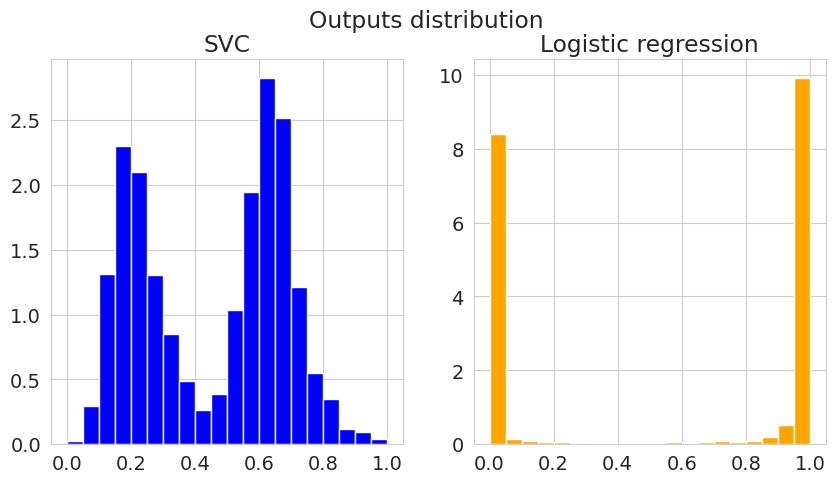

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(svc_pred, bins=20, color="blue", density="True")
axs[1].hist(lr_pred, bins=20, color="orange", density="True")

axs[0].set_title("SVC")
axs[1].set_title("Logistic regression")

plt.suptitle("Outputs distribution")
plt.show()


По определению, мы называем откалиброванными прогнозы $\hat{y}$, такие что:

- если мы зафиксируем спрогнозированную вероятность $\hat{p}$ и возьмем все объекты с этой вероятностью,
то среди них $\hat{p}*100$ объектов действительно будут принадлежать положительному классу.

Мы видим, что "уверенность" логистической регрессии по классам сильнее, тогда как для SVC вероятности положительного класса имеют разные значения. Посмотрим, как это отражается на калибровочных кривых.


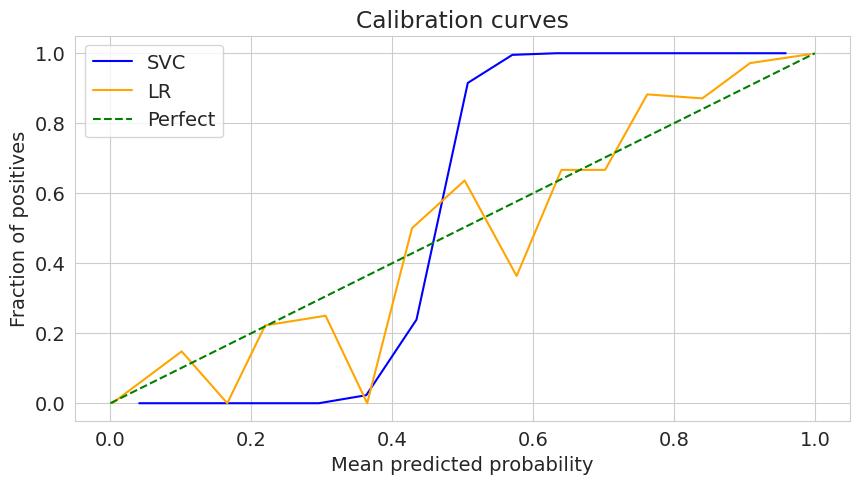

In [ ]:
plt.figure(figsize=(10, 5))

svc_true_prob, svc_pred_prob = calibration_curve(y_test, svc_pred, n_bins=15)
lr_true_prob, lr_pred_prob = calibration_curve(y_test, lr_pred, n_bins=15)

plt.plot(svc_pred_prob, svc_true_prob, label="SVC", color="blue")
plt.plot(lr_pred_prob, lr_true_prob, label="LR", color="orange")
plt.plot([0, 1], [0, 1], label="Perfect", linestyle="--", color="green")

plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curves")
plt.legend()
plt.show()

Кривая для логистической регрессии приближает диагональ лучше, чем кривая SVC. Чтобы понять, почему так, рассмотрим конкретную точку — 0.6.

Для всех объектов, вероятность которых быть принадлежащими классу 1 равна 0.6:
- для SVC - 100% объектов принадлежат положительному классу;
- для LR - 50% объектов принадлежат положительному классу.  

Попробуем откалибровать классификаторы и построить новые кривые.

Говоря в терминах событий:
- когда SVC уверен в событии на 60%, оно всегда происходит;
- когда LR уверенна в событии на 60%, оно происходит в 50% случаев.

**Следовательно, видна проблема**

Обе модели имеют хорошую предсказательную точность, но соответствие их вероятностей эмпирическим данным различно. Именно эту проблему мы будем убирать методами калибровки.


Чтобы лучше оценить чувствительность калибровки модели к эмпирическим вероятностям, рассмотрим синтетический пример с теми же данными в условиях дисбаланса.

In [ ]:
minority_class = 0
majority_class = 1

X_min = X[y == minority_class]
X_maj = X[y == majority_class]
y_min = y[y == minority_class]
y_maj = y[y == majority_class]

# Возьмём мало класса 0 и много класса 1
X_sub = pd.concat(
    [X_min.sample(frac=0.3, random_state=42), X_maj.sample(frac=1.0, random_state=42)]
)
y_sub = pd.concat(
    [y_min.sample(frac=0.3, random_state=42), y_maj.sample(frac=1.0, random_state=42)]
)


# Train Test
X_train_imb, X_test_imb, y_train_imb, y_test_imb = train_test_split(
    X_sub, y_sub, test_size=0.4, random_state=42, stratify=None
)

# Масштабирование
scaler = StandardScaler().fit(X_train_imb)
X_train_imb = scaler.transform(X_train_imb)
X_test_imb = scaler.transform(X_test_imb)

# Проверяем распределение классов
print("Class distributions")
display(
    pd.concat(
        [
            y_train_imb.value_counts(normalize=True),
            y_test_imb.value_counts(normalize=True),
        ],
        axis=1,
        keys=["Train", "Test"],
    )
)

Class distributions


,Train,Test
Class,,
1,0.804473,0.799116
0,0.195527,0.200884


Будем записывать все метрики в датафрейм для красоты.

In [ ]:
cal_metrics = []
probas = []

In [ ]:
# Проверяем модели
svc_imb = LinearSVC(max_iter=100000, C=0.1).fit(X_train_imb, y_train_imb)
svc_pred_imb = svc_imb.decision_function(X_test_imb)
svc_pred_imb = (
    (svc_pred_imb - svc_pred_imb.min())
    /
    (svc_pred_imb.max() - svc_pred_imb.min())
)

lr_imb = LogisticRegression(max_iter=100000, C=0.1).fit(X_train_imb, y_train_imb)
lr_pred_imb = lr_imb.predict_proba(X_test_imb)[:, 1]  # Вероятность положителнього класса

cal_metrics.extend(
    [
        {
            "model": "SVC",
            "metric": "ROC-AUC",
            "calibration": "None",
            "score": roc_auc_score(y_test_imb, svc_pred_imb),
        },
        {
            "model": "LogReg",
            "metric": "ROC-AUC",
            "calibration": "None",
            "score": roc_auc_score(y_test_imb, lr_pred_imb),
        },
    ]
)

probas.extend(
    [
        {"model": "SVC", "calibration": "None", "proba": svc_pred},
        {"model": "LogReg", "calibration": "None", "proba": lr_pred},
    ]
)

In [ ]:
pd.DataFrame(cal_metrics)

,model,metric,calibration,score
0,SVC,ROC-AUC,None,0.998224
1,LogReg,ROC-AUC,None,0.998038


Качество моделей по AUC осталось неизменно хорошим. Теперь посмотрим на вероятности и калибровочные кривые зная, что наши эмприрические частоты в тестовой выборке таковы:

*   1 - 0.799116
*   0 - 0.200884




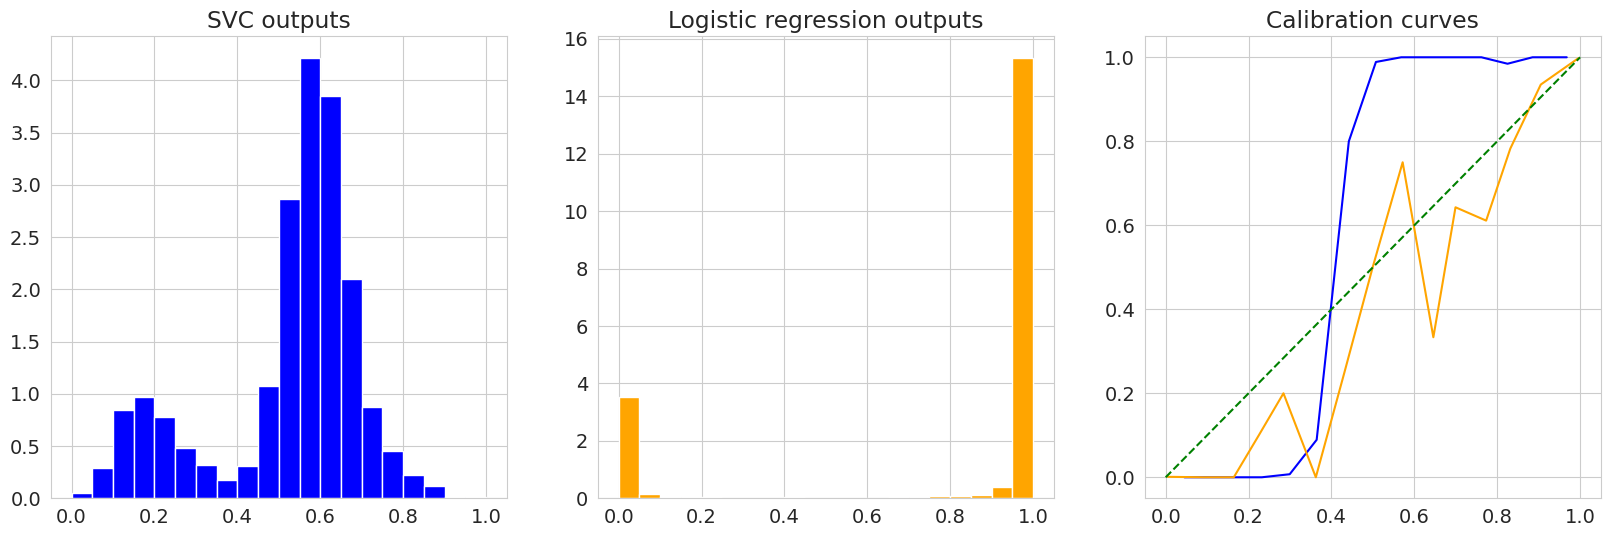

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

svc_true_prob_imb, svc_pred_prob_imb = calibration_curve(
    y_test_imb, svc_pred_imb, n_bins=15
)
lr_true_prob_imb, lr_pred_prob_imb = calibration_curve(
    y_test_imb, lr_pred_imb, n_bins=15
)

axs[0].hist(svc_pred_imb, bins=20, color="blue", density="True")
axs[1].hist(lr_pred_imb, bins=20, color="orange", density="True")
axs[2].plot(svc_pred_prob_imb, svc_true_prob_imb, label="SVC", color="blue")
axs[2].plot(lr_pred_prob_imb, lr_true_prob_imb, label="LR", color="orange")
axs[2].plot([0, 1], [0, 1], label="Perfect", linestyle="--", color="green")


axs[0].set_title("SVC outputs")
axs[1].set_title("Logistic regression outputs")
axs[2].set_title("Calibration curves")

plt.show()

 Ситуация аналогична сбалансированному случаю, с поправкой на эмпирические частоты.

## **Количественная оценка калибровки: Log Loss, Brier Score**

Как видно выше, roc-auc не дает информации о качестве калибровки вероятностей. Чтобы не прибегать всегда к визуальной оценке (хотя это наглядно), можно использовать количественные метрики. Основные из таких — Log Loss и Brier Score.

**LogLoss**

$$
L = -\frac{1}{n}\sum_{i=1}^n \Big(y_i \log p_i + (1-y_i)\log (1-p_i)\Big),
$$

- В идеальном случае Log Loss равна 0.
- В худшем случае Log Loss стремится к $∞$.

**Brier Score**

$$
\mbox{Brier_score} = \frac{1}{n} \left(\sum_{i} (y_i-p_i)^2 \right)
$$

- В худшем случае Brier score равна 1.
- В лучшем случае Brier score $\to$ 0.

In [ ]:
cal_metrics.extend(
    [
        {
            "model": "LogReg",
            "metric": "BrierScore",
            "calibration": "None",
            "score": brier_score_loss(y_test, lr_pred),
        },
        {
            "model": "SVC",
            "metric": "BrierScore",
            "calibration": "None",
            "score": brier_score_loss(y_test, svc_pred),
        },
        {
            "model": "LogReg",
            "metric": "LogLoss",
            "calibration": "None",
            "score": log_loss(y_test, lr_pred),
        },
        {
            "model": "SVC",
            "metric": "LogLoss",
            "calibration": "None",
            "score": log_loss(y_test, svc_pred),
        },
    ]
)

In [ ]:
metrics = pd.DataFrame(cal_metrics)
metrics[metrics.metric.isin(["BrierScore", "LogLoss"])]

,model,metric,calibration,score
2,LogReg,BrierScore,None,0.009350
3,SVC,BrierScore,None,0.099743
4,LogReg,LogLoss,None,0.035032
5,SVC,LogLoss,None,0.364177


Как можно заметить, SVC на порядок проигрывает по обеим метрикам.

## **Методы калибровки**

Классическими методами калибровки являются калибровка Платта (сигмоидная) и изотоническая регрессия. Оба этих метода реализованы в [`sklearn`](https://scikit-learn.org/stable/modules/calibration.html#calibration).

**Калибровка Платта**

Допустим, у нас есть обученный класификатор $b(x)$, который выдает уверенность (скор) в том, что $x$ относится к положительному классу. Метод приближает вероятность положительного класса с помощью сигмоидной функции:

$$
p\big(y = +1 \big| b(x)\big) = \frac{1}{1 + \exp (A \cdot b(x) + C)}
$$

Здесь обучаемыми параметрами являются $A, C \in \mathbb{R}$, их подбирают с помощью метода максимального правдоподобия (точно так же, как в логистической регрессии). Сделать это можно по кросс-валидации или на отложенной выборке.

**Изотоническая регрессия**

Другой метод использует так называемую изотоническую функцию &mdash; кусочно-линейную возрастающую функцию $f: \mathbb{R} \rightarrow \mathbb{R}$. Функция подбирается так, чтобы минимизировать MSE по выборке:

$$
\frac{1}{\ell} \sum_{i=1}^\ell \big(y_i - f(b(x_i))\big)^2 \rightarrow \min_f
$$

Этот метод склонен к переобучению, поэтому его рекомендуется применять только для больших выборок.

Кроме того, может не быть большого смысла калибровать логистическую регрессию, но мы проведем небольшой эксперимент.

Калибровку проводят на отложенной выборке, выделенной под неё. Иногда присутствует практика калибровки на тренировочных данных. Мы отложили выборку выше, так что будем использовать её.

Дляя анализа, посмотрим на метрики, в том числе те, которые от вероятностей не зависят и проверим, есть ли наблюдаемый эффект

In [ ]:
def log_metric(model_name, method, y_test, calibrated_model_proba):

    cal_metrics.extend(
        [
            {
                "model": model_name,
                "metric": "ROC-AUC",
                "calibration": method,
                "score": roc_auc_score(y_test, calibrated_model_proba),
            },
            {
                "model": model_name,
                "metric": "LogLoss",
                "calibration": method,
                "score": log_loss(y_test, calibrated_model_proba),
            },
            {
                "model": model_name,
                "metric": "BrierScore",
                "calibration": method,
                "score": brier_score_loss(y_test, calibrated_model_proba),
            },
        ]
    )

    probas.extend(
        [
            {
                "model": model_name,
                "calibration": method,
                "proba": calibrated_model_proba,
            },
        ]
    )

In [ ]:
for model, model_name in zip([svc, lr], ("SVC", "LogReg")):
    for method in ["Sigmoid", "Isotonic"]:

        calibrated_model = CalibratedClassifierCV(model, cv=3, method=method.lower()).fit(X_cal, y_cal)
        calibrated_model_proba = calibrated_model.predict_proba(X_test)[:, 1]

        log_metric(model_name, method, y_test, calibrated_model_proba)

In [ ]:
metrics_df = pd.DataFrame(cal_metrics)
probas_df = pd.DataFrame(probas)

print("SVC Metrics")
metrics_df[metrics_df.model == "SVC"].pivot(
    columns=["calibration"], index=["metric"], values=["score"]
)["score"][["None", "Sigmoid", "Isotonic"]]

SVC Metrics


calibration,None,Sigmoid,Isotonic
metric,,,
BrierScore,0.099743,0.008806,0.008632
LogLoss,0.364177,0.032401,0.030417
ROC-AUC,0.998224,0.999347,0.999328


Из интересного здесь следующее:
- ROC-AUC практически не изменился при калибровке, несмотря на то что эта метрика использует вероятности. Причина в том, что ROC-AUC зависит только от порядка предсказаний (рангов), а калибровка — это монотонное преобразование вероятностей. Следовательно, относительный порядок объектов не меняется, и значение метрики остаётся прежним. То же самое будет выполнено для любых метрик, которые опираются исключительно на метки классов или порядок вероятностей, а не на их абсолютные значения.
- калибровка Платта сильно улучшила и BrierScore, и LogLoss
- изотоническая регрессия тоже, причем показывает лучшее качество, хотя и незначительно

Теперь взглянем на логистическую регрессию

In [ ]:
print("LogReg Metrics")
metrics_df[metrics_df.model == "LogReg"].pivot(
    columns=["calibration"], index=["metric"], values=["score"]
)["score"][["None", "Sigmoid", "Isotonic"]]

LogReg Metrics


calibration,None,Sigmoid,Isotonic
metric,,,
BrierScore,0.009350,0.009643,0.009460
LogLoss,0.035032,0.035662,0.035123
ROC-AUC,0.998038,0.999182,0.999133


Как видим, тут практически нет изменений, что в ROC-AUC, что в других метриках поскольку модель изначаьно неплохо оценивает вероятности.

Построим новые калибровочные кривые:

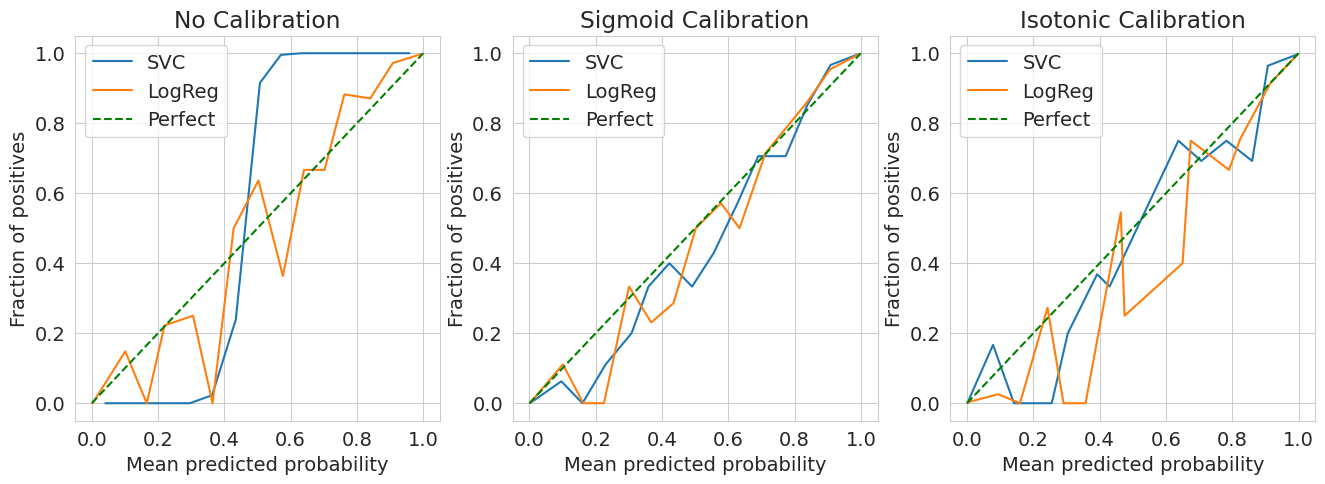

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

for idx, calibration in enumerate(["None", "Sigmoid", "Isotonic"]):

    for model in ["SVC", "LogReg"]:

        true_prob, pred_prob = calibration_curve(
            y_test,
            probas_df[(probas_df.model == model) & (probas_df.calibration == calibration)]["proba"].item(),
            n_bins=15,
        )

        axs[idx].plot(pred_prob, true_prob, label=model)

    axs[idx].plot([0, 1], [0, 1], label="Perfect", linestyle="--", color="green")
    if calibration == "None":
        calibration = "No"
    axs[idx].set_title(f"{calibration} Calibration")

for ax in axs:
    ax.set_xlabel("Mean predicted probability")
    ax.set_ylabel("Fraction of positives")
    ax.legend()

plt.show()

Как мы видим, калибровка Платта действительно улучшила вероятности, которые получаются у SVC и сильнее приблизила к идеальным вероятности логистической модели.

В то же время изотоническая регрессия улучшила вероятности SVC, но ухудшила кривую логистической регрессии. Это может сигнализировать о том, что метод немного переобучился, хоть у нас и была достаточно большая выборка.

## **Мультиклассовый случай**

В задачах с более чем двумя классами проблема калибровки модифицируется. А именно, теперь нам необходим корректные вероятности для всех категорий, которые должны суммироваться в единицу. Один из подходов к мультиклассовой калибровке — сведение задачи к набору бинарных классификаций с последующим объединением результатов.

Существует несколько стандартных способов разложения многоклассовой задачи на бинарные подзадачи. Базовые:


- One-vs-One (all pairs). Для классов $c_1, c_2, ..., c_n$ строим $\frac{n(n-1)}{2}$ классификаторов и калибруем каждый из них.
- One-vs-All: для $n$ классов обучаем $n$ классификаторов «один класс против всех остальных».

В sklearn и других библиотеках (например, `SplineCalib`) реализована калибровка на основе One-vs-All.

Посмотрим на пример. Чтобы перейти к многоклассовой классификации — уйдем от риса и возьмем ирисы. В качестве классификатора возьмем случайный лес, который также может из коробки давать вероятости.


In [ ]:
multiclass_results = []

In [ ]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize

X_multiclass, y_multiclass = load_iris(return_X_y=True)

X_train_multiclass, X_temp_multiclass, y_train_multiclass, y_temp_multiclass = (
    train_test_split(
        X_multiclass,
        y_multiclass,
        test_size=0.4,
        random_state=42,
        stratify=y_multiclass,
    )
)
X_valid_multiclass, X_test_multiclass, y_valid_multiclass, y_test_multiclass = (
    train_test_split(
        X_temp_multiclass,
        y_temp_multiclass,
        test_size=0.5,
        random_state=42,
        stratify=y_temp_multiclass,
    )
)

clf = RandomForestClassifier(random_state=999, max_depth=1)

# обучаем без калибровки
clf.fit(X_train_multiclass, y_train_multiclass)
probs_base = clf.predict_proba(X_test_multiclass)

multiclass_results.extend(
    [
        {
            "Calibration": None,
            "LogLoss": log_loss(y_test_multiclass, probs_base),
            "BrierScore": brier_score_loss(
                label_binarize(y_test_multiclass, classes=[0, 1, 2]).ravel(),
                probs_base.ravel(),
            ),
        }
    ]
)

pd.DataFrame(multiclass_results)

,Calibration,LogLoss,BrierScore
0,None,0.477278,0.098811


Посмотрим на эмприрические распределения в данных.

In [ ]:
for y, name in zip(
    [y_train_multiclass, y_valid_multiclass, y_test_multiclass],
    ["Train", "Calibration", "Test"],
):
    data = pd.DataFrame(np.unique(y, return_counts=True))
    print(name)
    display(data)
    print("\n")

Train


,0,1,2
0,0,1,2
1,30,30,30




Calibration


,0,1,2
0,0,1,2
1,10,10,10




Test


,0,1,2
0,0,1,2
1,10,10,10


Классы идеально сбалансированны. Как выглядят вероятности леса?

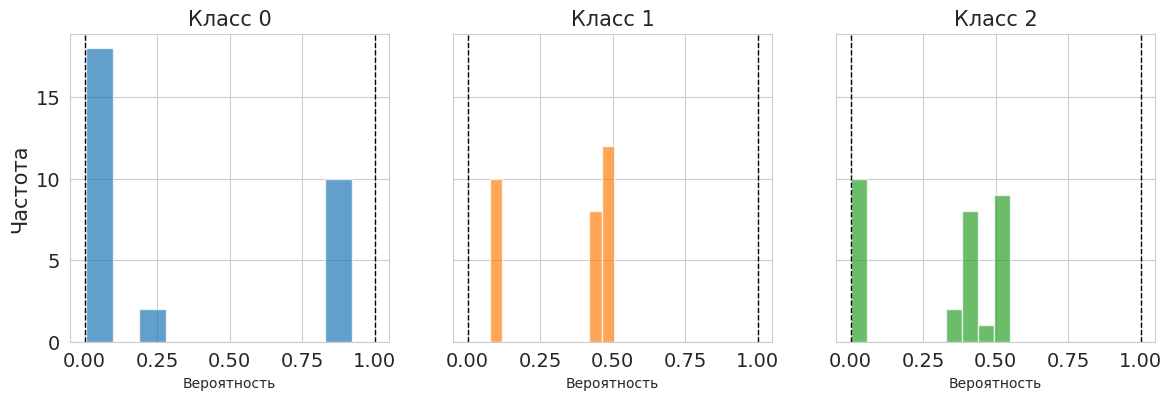

In [ ]:
import matplotlib.pyplot as plt

probas_unc_multiclass = clf.predict_proba(X_test_multiclass)
n_classes = probas_unc_multiclass.shape[1]

fig, axes = plt.subplots(1, n_classes, figsize=(14, 4), sharey=True)

for i in range(n_classes):
    axes[i].hist(probas_unc_multiclass[:, i], bins=10, alpha=0.7, color=f"C{i}")
    axes[i].set_title(f"Класс {i}", fontsize=15)
    axes[i].set_xlabel("Вероятность", fontsize=10)

    axes[i].axvline(x=0.0, color="black", linestyle="--", linewidth=1)
    axes[i].axvline(x=1.0, color="black", linestyle="--", linewidth=1)

    axes[i].set_xlim(-0.05, 1.05)

    if i == 0:
        axes[i].set_ylabel("Частота", fontsize=15)

Теперь выполним калибровку.

In [ ]:
from sklearn.frozen import FrozenEstimator

cal_clf = CalibratedClassifierCV(FrozenEstimator(clf), method="sigmoid")
cal_clf.fit(X_valid_multiclass, y_valid_multiclass)

probs_cal = cal_clf.predict_proba(X_test_multiclass)


multiclass_results.extend(
    [
        {
            "Calibration": "sigmoid",
            "LogLoss": log_loss(y_test_multiclass, probs_cal),
            "BrierScore": brier_score_loss(
                label_binarize(y_test_multiclass, classes=[0, 1, 2]).ravel(),
                probs_cal.ravel(),
            ),
        }
    ]
)


pd.DataFrame(multiclass_results)

,Calibration,LogLoss,BrierScore
0,None,0.477278,0.098811
1,sigmoid,0.377704,0.074093


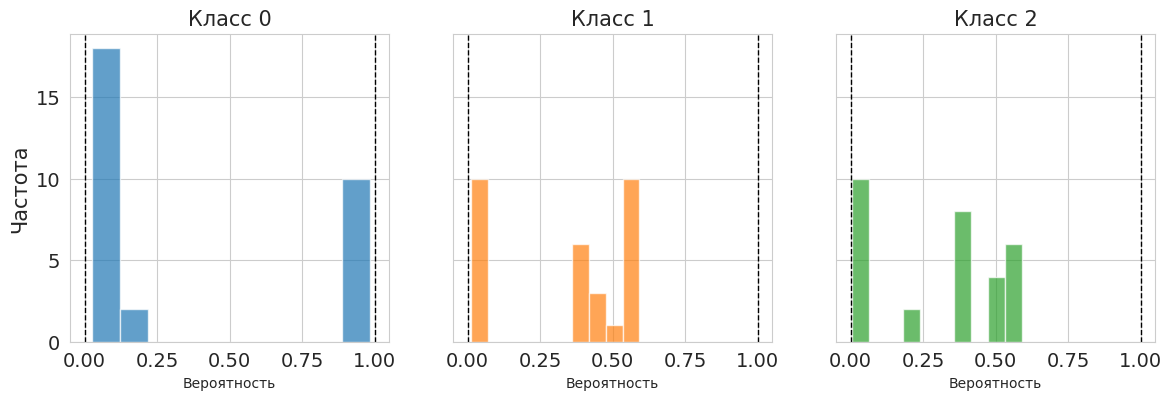

In [ ]:
import matplotlib.pyplot as plt

n_classes = probas_unc_multiclass.shape[1]

fig, axes = plt.subplots(1, n_classes, figsize=(14, 4), sharey=True)

for i in range(n_classes):
    axes[i].hist(probs_cal[:, i], bins=10, alpha=0.7, color=f"C{i}")
    axes[i].set_title(f"Класс {i}", fontsize=15)
    axes[i].set_xlabel("Вероятность", fontsize=10)

    axes[i].axvline(x=0.0, color="black", linestyle="--", linewidth=1)
    axes[i].axvline(x=1.0, color="black", linestyle="--", linewidth=1)

    axes[i].set_xlim(-0.05, 1.05)

    if i == 0:
        axes[i].set_ylabel("Частота", fontsize=15)

Калибровка незначимо, но улучшила вероятности. Если от результата требуется идеал, то, как мы упомянули в семинаре, стоит рассмотреть использование моделей, которые изначально строят многоклассовое распределение.

Также обратите внимание, что распределение вероятностей, даже после калибровки, не всегда имеет значения, близкие к единице в определенных классах. Даже в случае бинарной классификации калибровка нередко приводит к ситуации, когда, максимальная вероятность положительного класса, выдаваемая откалиброванной моделью, меньше 1. Это не баг, а фича, которая лишь говорит о том, что даже скалиброванная модель не бывает уверена на 100% процентов и следует смотреть в том числе на другие не менее важные метрики

## **Идеальное приближение**

В ходе семинара мы называли приемлемыми даже те случаи, где были отклонения от идеальной кривой. Причина кроется в доверительном интервале - это допустимый разброс, в пределах которого предсказанные вероятности всё ещё считаются корректными.

Быстро оценить доверительный интервал можно с помощью библиотеки `ml_insights`. Хотя этот инструмент и не новый, для нашей задачи он отлично подойдёт. Есть также альтернатива в виде более модного `relplot` от компании Apple

In [ ]:
!pip install -qU ml_insights relplot

В MLI есть два способа рассчета ДИ, относительно точки (`ci_ref='point'`) и относительно идеальной оси (`ci_ref='axis'`).

Первая стратегия `ci_ref='point'` показывает:

- с вероятностью  $1-\alpha$ эмпирическая вероятность может быть в этих дипазонах. В этом случае смотрим, попадает ли ДИ на идеальную кривую;

Вторая стратегия `ci_ref='axis'` показывает:

- с вероятностью $1-\alpha$ эмпирическая частота лежит в этом интервале. В этом случае смотрим, попадает ли точка в ДИ.


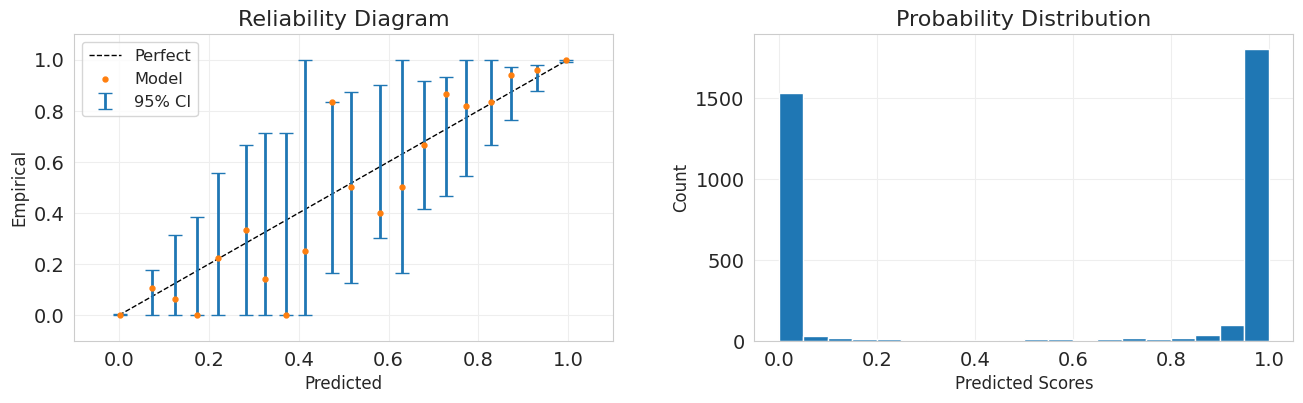

In [ ]:
import ml_insights as mli

plt.figure(figsize=(14, 5))
fig = mli.plot_reliability_diagram(
    y_test, lr_pred, show_histogram=True, ci_ref="axis", error_bar_alpha=0.05
)

Как видим, для регрессии прогнозы (все точки) находятся в ожидаемых ДИ.

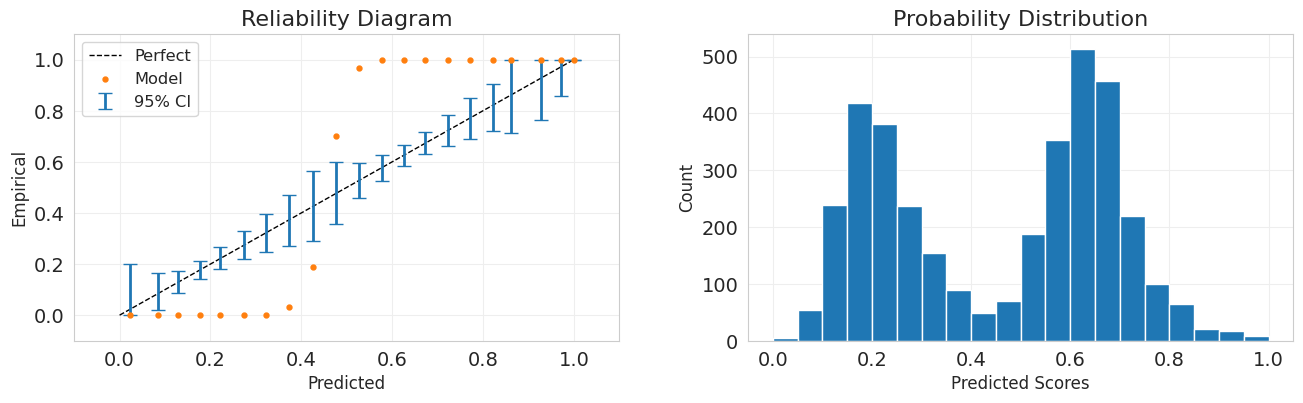

In [ ]:
plt.figure(figsize=(14, 5))
fig = mli.plot_reliability_diagram(
    y_test, svc_pred, show_histogram=True, ci_ref="axis", error_bar_alpha=0.05
)

Для SVC это уже не выполнено.

В `relplot` есть как привычные оценки, так и более интересные, например, бинаризованная калибровочная кривая, сглаженная и другие, о которых можете почитать в документации

In [ ]:
import relplot.diagrams as rd
from relplot.estimators import Binning
from sklearn.model_selection import GridSearchCV


def plot_compare(f, y, **kwargs):
    fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
    f, y = map(lambda x: np.array(x, dtype=np.double).reshape(-1).copy(), [f, y])

    plot_params = dict(
        split_densities=False,
        plot_density_ticks=True,
        plot_density=True,
        plot_confidence_band=False,
    )
    if kwargs is not None:
        plot_params.update(kwargs)
    num_bootstrap = 500

    binning = GridSearchCV(
        Binning(),
        param_grid={"bins_cnt": range(10, 25, 1)},
        cv=5,
        scoring="neg_mean_squared_error",
        verbose=1,
    )
    binning.fit(f.reshape(-1, 1), y - f)
    nbins = binning.best_params_["bins_cnt"]
    # binning = Binning(15)

    _ = rd.rel_diagram_binned(f, y, fig=fig, ax=axs[0], nbins=nbins)
    axs[0].set_title("BinnedECE")

    _ = rd.rel_diagram(
        f, y, fig=fig, ax=axs[1], num_bootstrap=num_bootstrap, **plot_params
    )
    axs[1].set_title("SmoothECE")
    return fig, axs

Fitting 5 folds for each of 15 candidates, totalling 75 fits


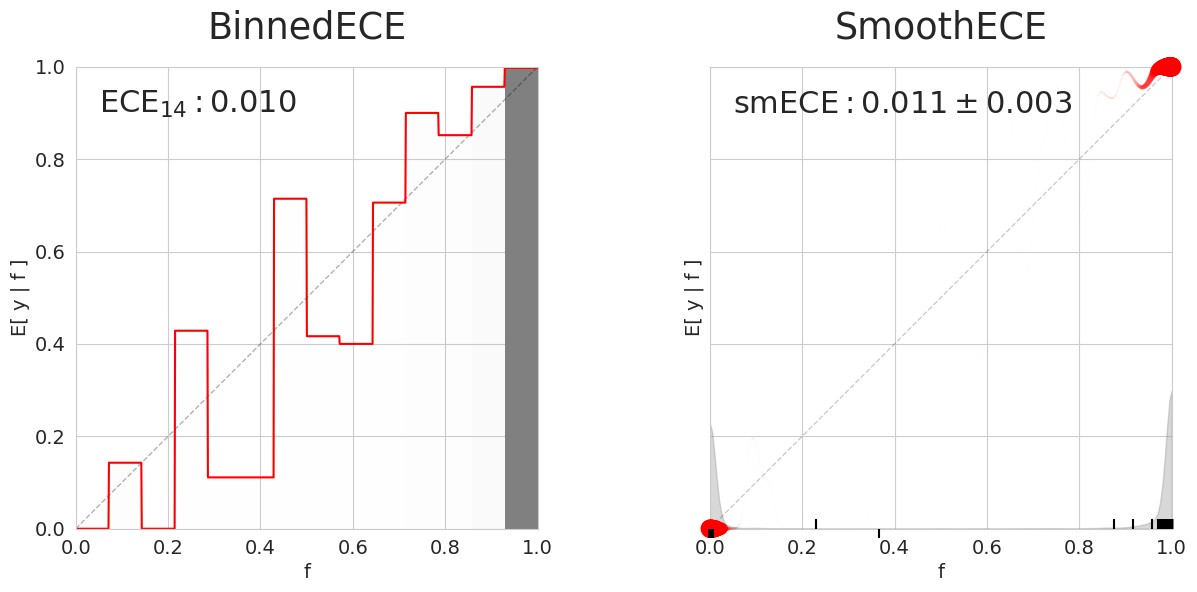

In [ ]:
fig, axs = plot_compare(lr_pred, y_test)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


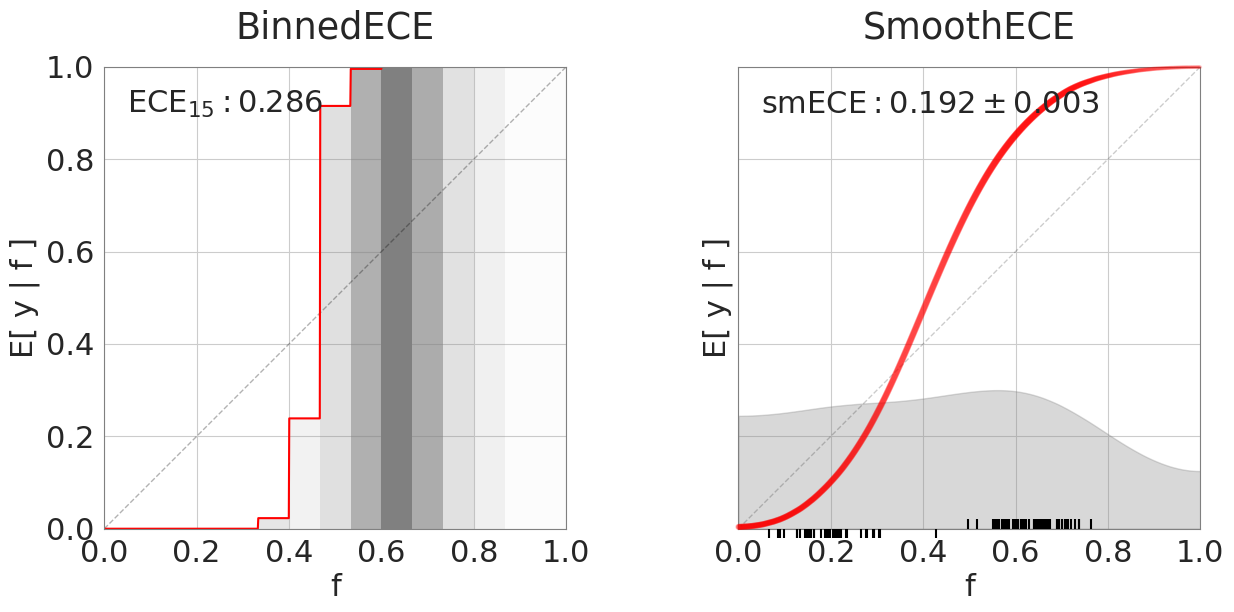

In [ ]:
fig, axs = plot_compare(svc_pred, y_test)

## **Другие методы калибровки для ознакомления**

На практике часто достаточно изотонической регрессии или калибровки Платта. Однако, если они показывают неудовлетворительный результат на данных, можно также рассмотреть другие варианты:
1. [**Beta Calubration**](https://pypi.org/project/betacal/), которая, как мы кратко обсудили в лекционном материале, продолжает калибровку Платта
2. [**SplineCalib**](https://ml-insights.readthedocs.io/en/latest/splinecalib_class.html) из библиотеки **ML insights**.
3. [**Venn-Abers**](https://github.com/ip200/venn-abers), который зачастую показывает лучший результат за те же деньги

Еще больше методов можно найти в соответствующих [пакетах](https://github.com/EFS-OpenSource/calibration-framework), [статьях](https://proceedings.mlr.press/v77/leathart17a/leathart17a.pdf) или [курсах](https://github.com/numeristical/resources/blob/master/CalibrationWorkshop/Calibration_Workshop_1.ipynb)

In [ ]:
!pip install -qU betacal venn-abers

In [ ]:
model = svc
model_name = "SVC"

In [ ]:
from venn_abers import VennAbersCV

method = "Venn-Abers"

# черная магия, чтобы venn-abers заработал в классах без predict_proba
model.predict_proba = lambda x: np.vstack(
    [model.decision_function(x), model.decision_function(x)]
).T
va = VennAbersCV(
    estimator=model, inductive=True, cal_size=0.2, random_state=101, shuffle=False
)
va.fit(X_train, y_train.values)
calibrated_model_proba = va.predict_proba(X_test)[:, 1]

log_metric(model_name, method, y_test, calibrated_model_proba)

In [ ]:
from betacal import BetaCalibration

method = "Beta"

# черная магия, чтобы va заработал в классах без predict_proba
bc = BetaCalibration()
bc.fit(model.predict_proba(X_train)[:, 1], y_train.values)
calibrated_model_proba = bc.predict(model.predict_proba(X_test)[:, 1])

log_metric(model_name, method, y_test, calibrated_model_proba)

In [ ]:
from ml_insights import SplineCalib

method = "Spline"

# черная магия, чтобы va заработал в классах без predict_proba
sc = SplineCalib()
sc.fit(model.predict_proba(X_train)[:, 1], y_train.values)
calibrated_model_proba = sc.calibrate(model.predict_proba(X_test)[:, 1])

log_metric(model_name, method, y_test, calibrated_model_proba)

In [ ]:
# простите, любители пандаса, так будет гораздо проще
import polars as pl

metrics = pd.DataFrame(cal_metrics)
probas_df = pd.DataFrame(probas)
print("SVC Metrics")

display(
    pl.from_pandas(metrics)
    .filter(pl.col("model") == "SVC")
    .sort("score")
    .group_by("metric")
    .agg(pl.col("score", "calibration").first())
)

print("SVC LogLoss")
display(
    pl.from_pandas(metrics)
    .filter((pl.col("model") == "SVC") & (pl.col("metric") == "LogLoss"))
    .sort("score")
)

SVC Metrics


metric,score,calibration
str,f64,str
"""LogLoss""",0.030417,"""Isotonic"""
"""BrierScore""",0.008632,"""Isotonic"""
"""ROC-AUC""",0.995556,"""Beta"""


SVC LogLoss


model,metric,calibration,score
str,str,str,f64
"""SVC""","""LogLoss""","""Isotonic""",0.030417
"""SVC""","""LogLoss""","""Sigmoid""",0.032401
"""SVC""","""LogLoss""","""Venn-Abers""",0.036094
"""SVC""","""LogLoss""","""Spline""",0.044212
"""SVC""","""LogLoss""","""Beta""",0.046303
"""SVC""","""LogLoss""","""None""",0.364177


Как видно, новые методы кардинально не улучшили ситуацию, но, как и всегда в мире машинного обучения, никогда не известно, что именно зайдет в конкретной задаче, поэтому не стоит сразу списывать их со счетов

Наконец, построим финальный график калибровочных кривых. Линий там довольно много, поэтому он сделан интерактивным, при желании можете потыкать и убрать часть из них

In [ ]:
!pip install -qU plotly

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=[0, 1], y=[0, 1], line=dict(dash="dash", color="green"), name="Perfect"
    )
)


for idx, method in enumerate(
    ["None", "Sigmoid", "Isotonic", "Spline", "Beta", "Venn-Abers"]
):

    svc_true_prob, svc_pred_prob = calibration_curve(
        y_test,
        probas_df[(probas_df.model == "SVC") & (probas_df.calibration == method)][
            "proba"
        ].item(),
        n_bins=15,
    )

    fig.add_trace(go.Scatter(x=svc_pred_prob, y=svc_true_prob, name=method))

fig.update_layout(
    height=800,
    title="Calibration Comparison",
    xaxis=dict(title=dict(text="Mean predicted probability")),
    yaxis=dict(title=dict(text="Fraction of positives")),
    legend=dict(title=dict(text="Calibration")),
)
fig.show()

Какого-то лучшего метода, увы не существует. Выбирать калибровочную кривую под вашу задачу - это уже искусство. Можно лишь рассудить, что какие-то методы, например, сплайн-калибровка плохо показывают себя на объектах с низкой вероятностью, какие-то наоборот, на объектах с высокой. Что из этого лучше уже зависит от постановки задачи. Думайте и исследуйте!